In [ ]:
!pip install -q dagshub mlflow

In [ ]:
import pandas as pd
import numpy as np

### Loading Our Bitcoin Data

In [ ]:
df = pd.read_csv('bitcoin.csv' , parse_dates=['Start' , 'End'] , index_col=['Start'])

In [ ]:
df.head()

In [ ]:
df = df.drop('End' , axis=1)

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

In [ ]:
df.info()

In [ ]:
len(df)

In [ ]:
btc = pd.DataFrame(df['Close']).rename(columns={'Close' : 'Price'})[::-1]

In [ ]:
btc

In [ ]:
import matplotlib.pyplot as plt

btc.plot(figsize=(15,10))
plt.ylabel("BTC Price ($)")
plt.xlabel("Date")
plt.title("Price Of Bitcoin From 2010-07-17 to 2025-03-30")
plt.show()

### Creating Train and Test Sets

In [ ]:
# Note : We can not use sklearn's train test split module here as that randomly slits the train and test splits.

In [ ]:
timestamps = btc.index.to_numpy()
prices = btc['Price'].to_numpy()

In [ ]:
split_size = int(0.80 * len(prices))

In [ ]:
X_train , y_train = timestamps[:split_size] , prices[:split_size]
X_test , y_test = timestamps[split_size:] , prices[split_size:]

In [ ]:
len(X_train) , len(y_train) , len(X_test) , len(y_test)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(X_train , y_train , s=5 , label = "Train Data")
plt.scatter(X_test , y_test , s=5 , label = "Test Data" )
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price($)")
plt.title("Train and Test Data of Bitcoin Price")
plt.show()

In [ ]:
# Function To Create Time Series Data

def plot_time_series(timestamps , values , format = "." , start=0 , end = None , label = None):
  plt.plot(timestamps[start:end] , values[start:end] , format , label = label)
  plt.xlabel("Date")
  plt.ylabel("Price ($)")
  if label:
    plt.legend(fontsize = 10)
  plt.grid(True)

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train , values = y_train , label = "Train Data")
plot_time_series(timestamps=X_test , values = y_test , label = "Test Data")

### Modelling Experiments

**Terms :**
 - **Horizon** : Number of timesteps into the future we are going to predict.
 - **Window** : Number of timesteps we are going to use to predict **horizon**.


---



#### Experiment - 0
 - Naive Model (Baseline)

In [ ]:
import dagshub
import mlflow
dagshub.init(repo_owner='Shrijeet14', repo_name='BitScry', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/Shrijeet14/BitScry.mlflow/")

In [ ]:
# Set or create an experiment
# mlflow.create_experiment("Algorithms")
mlflow.set_experiment("Algorithms")

In [ ]:
def log_mlflow_regression(model_name, model, Horizon, Window, model_results):
    import mlflow
    import mlflow.sklearn
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"{model_name}_Horizon{Horizon}_Window{Window}")
        mlflow.set_tag("experiment_type", "algorithm_comparison")
        mlflow.log_param("algo_name", model_name)
        for metric_name, value in model_results.items():
            mlflow.log_metric(metric_name, value)
        mlflow.sklearn.log_model(model, f"{model_name}_Horizon{Horizon}_Window{Window}")

##### Theory About Naive Forecast

Naïve forecasting assumes that the next value in a time series will be the same as the last observed value. It is often used as a baseline model in time series forecasting.  

**Mathematical Formula:**  
$$ \hat{y}_{t+1} = y_t $$  
where $ \hat{y}_{t+1} $ is the predicted value for the next time step, and $\ {y}_{t} $ is the most recent observed value.  

**Key Point:**  
- Works well for stable trends but fails when the data has seasonality or trends.  

[Resource: Forecasting: Principles and Practice](https://otexts.com/fpp3/simple-methods.html)  


##### Implementation

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10]  , naive_forecast[-10:]

In [ ]:
y_test[-10:]

In [ ]:
#Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_train , values = y_train , format = "-", label = "Train Data")
plot_time_series(timestamps=X_test , values = y_test , format = "-", label = "Test Data")
plot_time_series(timestamps=X_test[1:] , values = naive_forecast  , label = "Naive Forecast")

In [ ]:
#Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timestamps=X_test , values = y_test , format = "-", label = "Test Data")
plot_time_series(timestamps=X_test[1:] , values = naive_forecast  , label = "Naive Forecast")

In [ ]:
import tensorflow as tf

In [ ]:
def mean_absolute_scaled_error(y_true , y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
    # Converting data into float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Mean Absolute Error
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_metric.update_state(y_true, y_pred)
    mae = mae_metric.result()

    # Mean Squared Error
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mse_metric.update_state(y_true, y_pred)
    mse = mse_metric.result()

    # Root Mean Squared Error (by taking the square root of MSE)
    rmse = tf.sqrt(mse)

    # Mean Absolute Percentage Error
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_metric.update_state(y_true, y_pred)
    mape = mape_metric.result()

    # Mean Absolute Scaled Error (assuming your custom function is defined similarly)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": float(mae.numpy()),
        "mse": float(mse.numpy()),
        "rmse": float(rmse.numpy()),
        "mape": float(mape.numpy()),
        "mase": float(mase.numpy())
    }


In [ ]:
naive_results = evaluate_preds(y_true = y_test[1:] , y_pred = naive_forecast)

In [ ]:
naive_results

In [ ]:
naive_results["mae"]

In [ ]:
avg_bitcoin_test_price = tf.reduce_mean(y_test)
avg_bitcoin_test_price

In [ ]:
def log_mlflow_naive(model_name, y_test, Horizon, Window):
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"{model_name}_Horizon{Horizon}_Window{Window}")
        mlflow.set_tag("experiment_type", "algorithm_comparison")
        mlflow.log_param("algo_name", model_name)
        naive_results = evaluate_preds(y_true = y_test[1:] , y_pred = naive_forecast)
        for metric_name, value in naive_results.items():
            mlflow.log_metric(metric_name, value)

In [ ]:
log_mlflow_naive("Naive_Model" , y_test , Horizon=1, Window=1)

#### Experiment - 1

##### Formatting Our Data
"Windowing our dataset"
  - Horizon = 1
  - Window = 7

In [ ]:
len(y_train)

In [ ]:
prices[:7]

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_window(x , horizon=HORIZON):
  return x[:,:-horizon] , x[:,-horizon:]

In [ ]:
def make_windows(x , window_size = WINDOW_SIZE , horizon = HORIZON):
  # step-1 : creating a window of specific window_size (adding the horizon on the end for labelling later)
  window_step  = np.expand_dims(np.arange(window_size+horizon) , axis=0)

  # step-2 : creating a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)) , axis = 0).T

  #step-3 : Indexing on the target array (a time series ) with 2D array of multiple window steps
  windowed = x[window_indexes]

  #step-4 : Getting the labelled windows
  windows , labels = get_labelled_window(windowed , horizon)
  return windows , labels

In [ ]:
final_windows , final_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon=HORIZON)

In [ ]:
len(final_windows) , len(final_labels)

In [ ]:
for i  in range(5000 , 5006):
  print(f"Window : {final_windows[i]}")
  print(f"Label : {final_labels[i]}")
  print("-"*50)

##### Turning  our created window into train and test sets

In [ ]:
final_windows[:5]  , final_labels[:5]

In [ ]:
def make_train_test_splits(windows , labels , test_split = 0.2):
  splits_size = int(len(windows) * (1-test_split))
  train_windows = windows[:splits_size]
  train_labels = labels[:splits_size]
  test_windows = windows[splits_size:]
  test_labels = labels[splits_size:]
  return train_windows , train_labels , test_windows ,  test_labels


In [ ]:
train_windows , train_labels , test_windows  , test_labels = make_train_test_splits(final_windows , final_labels)

In [ ]:
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

In [ ]:
# Checking if train labels are the same => Before and After Window Split
# Removing the horizon from train_labels, should make things comparable
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:len(train_labels) + WINDOW_SIZE - HORIZON])

In [ ]:
np.squeeze(train_labels[:-HORIZON])

In [ ]:
y_train[WINDOW_SIZE:len(train_labels) + WINDOW_SIZE - HORIZON]

##### Modelling Checkpoint Checkpoint

In [ ]:
# Creating a function to implement a ModelCheckpoint callback with a specific filename.
import os
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

##### Model-1 : Dense Model (Window = 7 , horizon = 1)

In [ ]:
tf.random.set_seed(42)

# 1. Construct Model
model1 = tf.keras.Sequential([
  layers.Dense(128 , activation="relu"),
  layers.Dense(HORIZON , activation="linear")
] , name = "Model_1_dense")

# Compiling the Model
model1.compile(
    loss = tf.keras.losses.mae ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae' , "mse"]
)

# Fitting the Model
# Assuming model1 is defined and compiled
model1.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model1.name)]
)


##### Evaluations and logging

In [ ]:
# Evaluating model
model1.evaluate(test_windows , test_labels)

In [ ]:
# Load in saved best performing model1 and evaluate it on test_data
model1 = tf.keras.models.load_model("model_experiments/Model_1_dense.keras")
model1.evaluate(test_windows , test_labels)

In [ ]:
# Making forecasts with model1
def make_preds(model , input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model1_preds = make_preds(model1 , test_windows)

In [ ]:
model1_preds[:10]

In [ ]:
test_labels[:10]

In [ ]:
test_labels.shape , model1_preds.shape

In [ ]:
tf.squeeze(test_labels).shape , model1_preds.shape

In [ ]:
model1_results = evaluate_preds(tf.squeeze(test_labels) , model1_preds)

In [ ]:
model1_results

In [ ]:
naive_results

In [ ]:
log_mlflow_regression("DenseW7H1", model1, HORIZON, WINDOW_SIZE, model1_results)

In [ ]:
offset = 500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[-len(test_windows):], start=offset, label="Test_data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model1_preds, start=offset, format="-", label="model1_preds")

#### Experiment - 2

#####Formatting Our Data
"Windowing our dataset"
  - Horizon = 1
  - Window = 30

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
final_windows , final_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon=HORIZON)

In [ ]:
for i  in range(5000 , 5006):
  print(f"Window : {final_windows[i]}")
  print(f"Label : {final_labels[i]}")
  print("-"*50)

##### Turning our created window into train and test sets

In [ ]:
final_windows[:5]  , final_labels[:5]

In [ ]:
train_windows , train_labels , test_windows  , test_labels = make_train_test_splits(final_windows , final_labels)

In [ ]:
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

In [ ]:
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:len(train_labels) + WINDOW_SIZE - HORIZON])

##### Model-2 : Dense Model (Window = 30 , horizon = 1)

In [ ]:
tf.random.set_seed(42)
# 1. Construct Model
model2 = tf.keras.Sequential([
  layers.Dense(128 , activation="relu"),
  layers.Dense(HORIZON , activation="linear")
] , name = "Model_2_dense")

# Compiling the Model
model2.compile(
    loss = tf.keras.losses.mae ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae' , "mse"]
)

# Fitting the Model
# Assuming model2 is defined and compiled
model2.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model2.name)]
)

##### Evaluations and logging

In [ ]:
# Evaluating model
model2.evaluate(test_windows , test_labels)

In [ ]:
# Load in saved best performing model1 and evaluate it on test_data
model2 = tf.keras.models.load_model("model_experiments/Model_2_dense.keras")
model2.evaluate(test_windows , test_labels)

In [ ]:
model2_preds = make_preds(model2 , test_windows)

In [ ]:
model2_results = evaluate_preds(tf.squeeze(test_labels) , model2_preds)

In [ ]:
model2_results

In [ ]:
log_mlflow_regression("DenseW30H1", model2, HORIZON, WINDOW_SIZE, model2_results)

In [ ]:
offset = 500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[-len(test_windows):], start=offset, label="Test_data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model2_preds, start=offset, format="-", label="model2_preds")

In [ ]:
offset = 500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[-len(test_windows):], start=offset, label="Test_data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model2_preds, start=offset, format="-", label="model2_preds")

#### Experiment - 3

##### Formatting Our Data
"Windowing our dataset"

- Horizon = 7
- Window = 30

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
final_windows , final_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon=HORIZON)

In [ ]:
final_labels

In [ ]:
for i  in range(5000 , 5006):
  print(f"Window : {final_windows[i]}")
  print(f"Label : {final_labels[i]}")
  print("-"*50)

##### Turning our created window into train and test sets

In [ ]:
final_windows[:5]  , final_labels[:5]

In [ ]:
train_windows , train_labels , test_windows  , test_labels = make_train_test_splits(final_windows , final_labels)

In [ ]:
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

In [ ]:
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:len(train_labels) + WINDOW_SIZE - HORIZON])

##### Model-3 : Dense Model (Window = 30 , horizon = 7)

In [ ]:
tf.random.set_seed(42)
# 1. Construct Model
model3 = tf.keras.Sequential([
  layers.Dense(128 , activation="relu"),
  layers.Dense(HORIZON , activation="linear")
] , name = "Model_3_dense")

# Compiling the Model
model3.compile(
    loss = tf.keras.losses.mae ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae' , "mse"]
)

# Fitting the Model
# Assuming model3 is defined and compiled
model3.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model3.name)]
)

##### Evaluations and logging

In [ ]:
# Evaluating model
model3.evaluate(test_windows , test_labels)

In [ ]:
# Load in saved best performing model1 and evaluate it on test_data
model3 = tf.keras.models.load_model("model_experiments/Model_3_dense.keras")
model3.evaluate(test_windows , test_labels)

In [ ]:
model3_preds = make_preds(model3 , test_windows)

In [ ]:
model3_results = evaluate_preds(tf.squeeze(test_labels) , model3_preds)

In [ ]:
model3_results

In [ ]:
log_mlflow_regression("DenseW30H7", model3, HORIZON, WINDOW_SIZE, model3_results)

In [ ]:
offset = 500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timestamps=X_test[-len(test_windows):], values=test_labels[-len(test_windows):], start=offset, label="Test_data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=model3_preds, start=offset, format="-", label="model3_preds")

In [ ]:
offset = 500
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timestamps=X_test[-len(test_windows):], values=tf.reduce_mean(test_labels[-len(test_windows):],axis=1), start=offset, label="Test_data")
plot_time_series(timestamps=X_test[-len(test_windows):], values=tf.reduce_mean(model3_preds,axis=1), start=offset, format="-", label="model3_preds")

##### Making evaluation fuction for higher Horizons

In [ ]:
def evaluate_preds(y_true, y_pred):
    # Converting data into float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Mean Absolute Error
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mae_metric.update_state(y_true, y_pred)
    mae = mae_metric.result()

    # Mean Squared Error
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mse_metric.update_state(y_true, y_pred)
    mse = mse_metric.result()

    # Root Mean Squared Error (by taking the square root of MSE)
    rmse = tf.sqrt(mse)

    # Mean Absolute Percentage Error
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()
    mape_metric.update_state(y_true, y_pred)
    mape = mape_metric.result()

    # Mean Absolute Scaled Error (assuming your custom function is defined similarly)
    mase = mean_absolute_scaled_error(y_true, y_pred)


    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
      mae = tf.reduce_mean(mae)
      mse = tf.reduce_mean(mse)
      rmse = tf.reduce_mean(rmse)
      mape = tf.reduce_mean(mape)
      mase = tf.reduce_mean(mase)


    return {
        "mae": float(mae.numpy()),
        "mse": float(mse.numpy()),
        "rmse": float(rmse.numpy()),
        "mape": float(mape.numpy()),
        "mase": float(mase.numpy())
    }


In [ ]:
model3_results = evaluate_preds(tf.squeeze(test_labels) , model3_preds)
model3_results

#### Experiment - 4

##### Formatting Our Data
- Model : Conv 1D model
- Window : 7
- Horizon : 1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
final_windows , final_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon=HORIZON)

In [ ]:
for i  in range(5000 , 5006):
  print(f"Window : {final_windows[i]}")
  print(f"Label : {final_labels[i]}")
  print("-"*50)

##### Turning our created window into train and test sets

In [ ]:
train_windows , train_labels , test_windows  , test_labels = make_train_test_splits(final_windows , final_labels)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

##### Model-4 : Conv-1D Model (Window = 7 , horizon = 1)

In [ ]:
tf.random.set_seed(42)

# Creating our Conv1D Model
model4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x , axis=1)),
    layers.Conv1D(filters=128 , kernel_size=5 , strides=1 , padding = 'causal' , activation = 'relu'),
    layers.Dense(HORIZON)
], name = "Model_4_conv1D")

# Compiling Model
model4.compile(
    loss = tf.keras.losses.mae ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae' , "mse"]
)

# Fitting our Model
model4.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model4.name)]
)

##### Evaluations and logging

In [ ]:
# Evaluating model
model4.evaluate(test_windows , test_labels)

In [ ]:
# Load in saved best performing model4 and evaluate it on test_data
# model4 = tf.keras.models.load_model("model_experiments/Model_4_conv1D.keras", safe_mode=False)
# model4 = tf.keras.models.load_model("model_experiments/Model_4_conv1D.keras")
# model4.evaluate(test_windows , test_labels)

In [ ]:
model4_preds = make_preds(model4 , test_windows)

In [ ]:
model4_results = evaluate_preds(tf.squeeze(test_labels) , model4_preds)

In [ ]:
model4_results

In [ ]:
log_mlflow_regression("Conv1D", model4, HORIZON, WINDOW_SIZE, model4_results)

#### Experiment - 5

##### Model5 :  Model LSTM (Window = 7 , horizon = 1)

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x , axis=1))(inputs)
x = layers.LSTM(128, activation='relu')(x) # Here we changed the default tanh activation to relu
outputs = layers.Dense(HORIZON)(x)
model5 = tf.keras.Model(inputs , outputs , name = "Model_5_LSTM")

model5.compile(
    loss = tf.keras.losses.mae ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae' , "mse"]
)

model5.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model5.name)]
)
# ______________________________________________________________________________
## Difficulty :
# My LSTM Model was giving very poor performance of about 40k val loss which is really bad , so i struggled with this problem a lot changed the Layer parameters but couldn't get anything , finally i changed the activation function of layer to relu which was initially is tanh and that improved the model a lot.

##### Evaluations and logging

In [ ]:
# model5 = tf.keras.models.load_model("model_experiments/Model_5_LSTM.keras")
model5.evaluate(test_windows , test_labels)

In [ ]:
model5_preds = make_preds(model5 , test_windows)

In [ ]:
model5_results = evaluate_preds(tf.squeeze(test_labels) , model5_preds)

In [ ]:
model5_results

In [ ]:
log_mlflow_regression("LSTM", model5, HORIZON, WINDOW_SIZE, model5_results)

#### Experiment - 6

##### Making a multivariate time series **dataset**

##### Let's add one more feature to out dataset and try to improve the performance

- 1st Bitcoin halving date — November 28, 2012 — Reward down: 50 BTC to 25 BTC

- 2nd Bitcoin halving date — July 9, 2016 — Reward down:  25 BTC to 12.5 BTC

- 3rd Bitcoin halving date — May 11, 2020 — Reward down:  12.5 BTC to 6.25 BTC

- 4th Bitcoin halving date — April 19, 2024 — Reward down: 6.25 BTC to 3.125 BTC

- 5th Bitcoin halving date — April 17, 2028 — Reward down: 3.125 BTC to 1.5625 BTC

In [ ]:
# @title Default title text
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125


block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")
block_reward_5_datetime = np.datetime64("2024-04-19")
block_reward_6_datetime = np.datetime64("2028-04-17")

In [ ]:
block_reward_2_days = (block_reward_2_datetime - btc.index[0]).days
block_reward_3_days = (block_reward_3_datetime - btc.index[0]).days
block_reward_4_days = (block_reward_4_datetime - btc.index[0]).days
block_reward_5_days = (block_reward_5_datetime - btc.index[0]).days
block_reward_6_days = (block_reward_6_datetime - btc.index[0]).days
block_reward_2_days, block_reward_3_days, block_reward_4_days , block_reward_5_days ,  block_reward_6_days

In [ ]:
btc.iloc[0]

In [ ]:
btc.iloc[5025]

In [ ]:
# Add block_reward column
bitcoin_prices_block = btc.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_1
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_4_days:block_reward_5_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_5_days:block_reward_6_days, -1] = block_reward_5
bitcoin_prices_block

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

##### Making Windowed Data and train and test sets

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [ ]:
bitcoin_prices_windowed.head()

In [ ]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

In [ ]:
y.head()

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

##### Model-5 : Dense model using multivariate time series

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model6.name)])

##### Evaluations and logging

In [ ]:
# Make sure best model is loaded and evaluate
model6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model6.evaluate(X_test, y_test)

In [ ]:
# Make predictions on multivariate data
model6_preds = tf.squeeze(model6.predict(X_test))

In [ ]:
# Evaluate preds
model6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model6_preds)

In [ ]:
model6_results

In [ ]:
log_mlflow_regression("MultiW7H1", model6, HORIZON, WINDOW_SIZE, model6_results)

#### Experiment - 7

##### N-Beats ALgorithm :
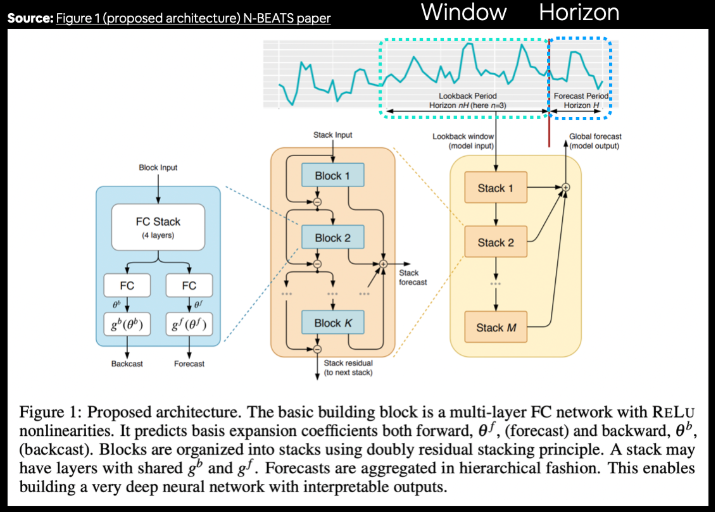

- N Beats block layer doesn't exist in tensorflow so we have to implement it ourselves.

In [ ]:

# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


##### Formatting Our Data
- Model : N-Beats Algorithm
- Window : 7
- Horizon : 1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
final_windows , final_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon=HORIZON)

In [ ]:
final_labels[0]

In [ ]:
btcNbeats = pd.DataFrame(prices, columns=['Price']) # Create DataFrame
for i in range(WINDOW_SIZE):
  btcNbeats[f"Price+{i+1}"] = btcNbeats["Price"].shift(periods=i+1)
btcNbeats.dropna().head()

##### Turning our created window into train and test sets

In [ ]:
X = btcNbeats.dropna().drop("Price", axis=1)
y = btcNbeats.dropna()["Price"]
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

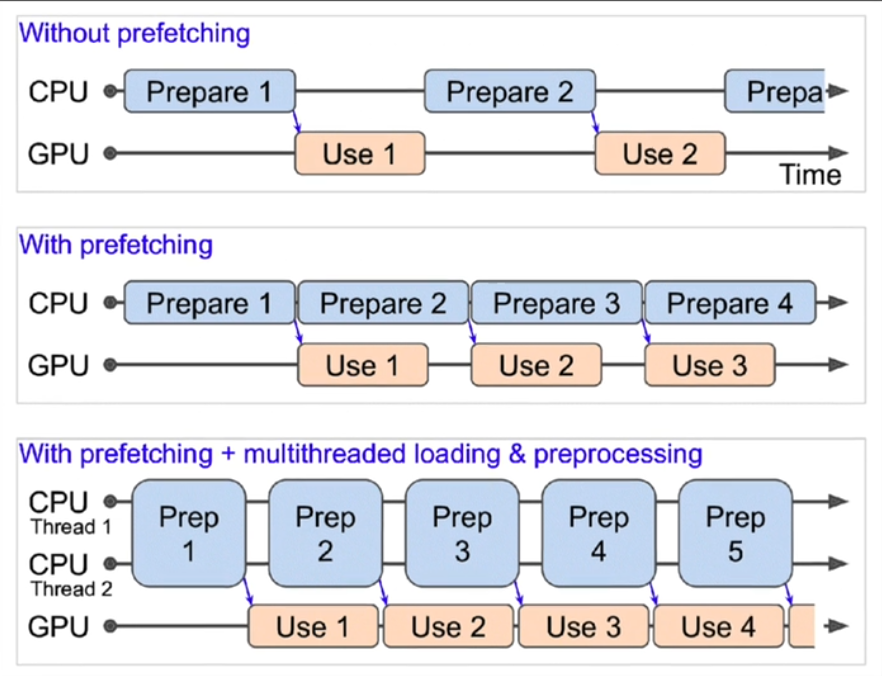

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

##### Setting up hyperparameters for N-Beats algorithm

In [ ]:
# Have taken these parameters from the research paper

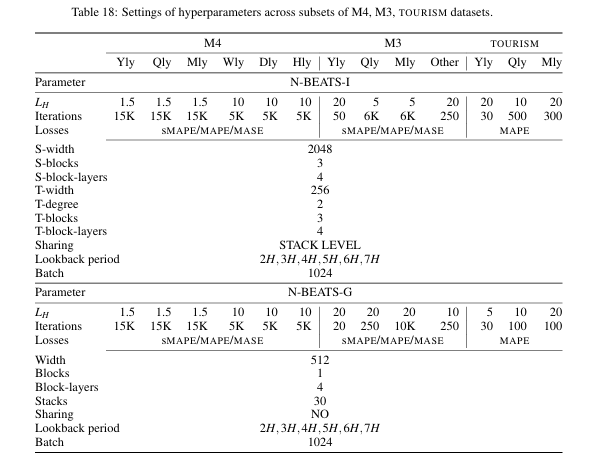

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE  + HORIZON

##### Creating Residual Networks

*N-BEATS Model Implementation Steps*

*1. Create the Basic Building Block*
- First, set up an `NBeatsBlock` layer that will serve as the foundational component
- This block will handle the initial transformations of your time series data

*2. Design the Input Layer*
- Create an input layer using Keras Functional API
- This layer will receive your time series data and feed it into the model

*3. Generate Initial Predictions*
- Use the block from step 1 to create:
  - An initial backcast (reconstruction of the input)
  - An initial forecast (prediction of future values)

*4. Build Stacked Architecture*
- Set up a for loop to create multiple stacks of blocks
- Each stack will further refine the model's predictions

*5. Create Block Layers Within Stacks*
- Inside the loop from step 4, create additional `NBeatsBlock` instances
- Each block will output its own backcast and forecast

*6. Implement Double Residual Stacking*
- Use subtract layers to calculate residuals between input and backcasts
- Use add layers to combine forecasts from different blocks
- This creates the "double residual" architecture that makes N-BEATS powerful

*7. Assemble the Complete Model*
- Connect all inputs and outputs using `tf.keras.Model()`
- This finalizes the model architecture

*8. Configure Model Training*
- Compile the model with:
  - Mean Absolute Error (MAE) loss function
  - Adam optimizer with default settings (as specified in the N-BEATS paper)

*9. Train With Smart Callbacks*
- Set up training for up to 5000 epochs with two key callbacks:
  - Early Stopping: Halt training if validation loss doesn't improve for 200 epochs
  - Learning Rate Reduction: Decrease learning rate by 10x if validation loss plateaus for 100 epochs

In [ ]:
%%time
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")
# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)
  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [ ]:
# Evaluate N-BEATS model on the test dataset
model7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model7_preds = make_preds(model7, test_dataset)
model7_preds[:10]

In [ ]:
model7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model7_preds)
model7_results

##### Plotting the N-Beats Algorithm

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model7, to_file='model.png', show_shapes=True, dpi=96)

In [ ]:
log_mlflow_regression("NbeatsW7H1", model7, HORIZON, WINDOW_SIZE, model7_results)

#### Experiment - 8

##### Model - 8 : ensemble model (stacking different models together )

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):

  ensemble_models = []

  # Create num_iter number of
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
  return ensemble_models

In [ ]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,num_epochs=1000)

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

##### Evaluations and logging

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

In [ ]:
log_mlflow_regression("Ensemble", ensemble_models , HORIZON, WINDOW_SIZE, ensemble_results)

##### Getting Upper And Lower Bounds

In [ ]:
def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

#### Experiment - 9

##### Formatting Our Data
- HORIZON = 1
- WINDOW_SIZE = 7

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [ ]:
bitcoin_prices_windowed

##### Future Prediction Model

In [ ]:
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
dataset_all

Model-9 : Dense Model (Window = 7 , Horizon = 1 , 1 more layer , using entire dataset)

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model9.fit(dataset_all,
            epochs=100,
            verbose=1)

##### Make Predictions into the future


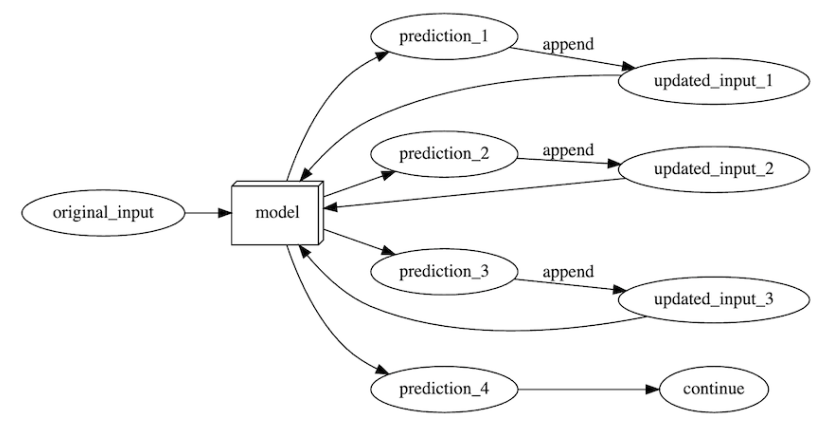

In [ ]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]
  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    future_forecast.append(tf.squeeze(future_pred).numpy())
    print(future_forecast)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
INTO_FUTURE = 14

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model7,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)
future_forecast

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = btc.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(btc.index, prices, start=5000, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

In [ ]:
INTO_FUTURE = 30
future_forecast = make_future_forecast(values=y_all,
                                       model=model7,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)
last_timestep = btc.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
plt.figure(figsize=(10, 7))
plot_time_series(btc.index, prices, start=5000, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

In [ ]:
d=zip(next_time_steps,future_forecast)
pd.DataFrame(d)

###  THE END